# Width and similarity modulo permutation
Does increasing width make weights closer modulo permutation?
Suppose weights of two neural network layers are drawn IID from the same distribution.

# Procedure 

1. Fix $d$ and a distribution $\mathcal{P}$ over $\mathbb{R}^d$.
2. Sample $n$ times from $\mathcal{P}$ twice to get $X$ and $Y$.
3. Compute Wasserstein distance $W(X, Y)$.
4. Plot distance relative to different $n$ and $d$.


# Theoretical predictions

Proposition 3.2 in [1] states that $|W(X, Y)| \to 0$ almost surely as $n \to \infty$ (since $X, Y$ are from the same distribution).
Furthermore, Corollary 3.5 in [1] gives the rate of convergence as of the order $\frac{(2n)^{d / (d+1)}}{n}$ for $d \geq 2$.

$$
W(X, Y)
$$


[1] Sriperumbudur, B. K., Fukumizu, K., Gretton, A., Schölkopf, B., & Lanckriet, G. R. (2012). On the empirical estimation of integral probability metrics.

In [136]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(6.5, 5)})

In [ ]:
CONSTANT = 4.

def get_sample(d, n):
    # 1. Fix $d$ and a distribution $\mathcal{P}$ over $\mathbb{R}^d$.
    # 2. Sample $n$ times from $\mathcal{P}$ twice to get $X$ and $Y$.
    x = np.random.randn(n, d)
    y = np.random.randn(n, d)
    # 3. Compute Wasserstein distance $W(X, Y)$.
    cost = euclidean_distances(x, y)
    _, perm_cols = linear_sum_assignment(cost, maximize=False)
    distance = np.sum(cost[np.arange(n), perm_cols]) / n
    return distance

# 4. Plot distance relative to different $n$ and $d$.
sim_df = []
for d in [2, 5, 10, 20, 50]:
    for n in [10, 20, 50, 100, 200, 500, 1000]:
        for replicate in range(10):
            distance = get_sample(d, n)
            sim_df.append({
                "d": d,
                "n": n,
                "w": distance,
                "replicate": replicate,
                "theory": CONSTANT * (2 * n) ** (d / (d + 1)) / n,
            })
sim_df = pd.DataFrame(sim_df)

In [109]:
# what about if we can optimize over both n and d?

def get_two_way_sample(d, n):
    # 1. Fix $d$ and a distribution $\mathcal{P}$ over $\mathbb{R}^d$.
    # 2. Sample $n$ times from $\mathcal{P}$ twice to get $X$ and $Y$.
    x = np.random.randn(n, d)
    y = np.random.randn(n, d)
    # 3. Compute Wasserstein distance $W(X, Y)$.
    prev_distance = [1e16, 1e16]
    for i in range(100):
        cost = euclidean_distances(x, y)
        _, perm_cols = linear_sum_assignment(cost, maximize=False)
        distance = np.sum(cost[np.arange(x.shape[0]), perm_cols]) / x.shape[0]
        # np.testing.assert_allclose(np.trace(euclidean_distances(x, y[perm_cols])) / x.shape[0], distance)
        if prev_distance[i % 2] - 1e-8 < distance:
            # print(i, distance, prev_distance)
            break
        prev_distance[i % 2] = distance
        x, y = x.T, y[perm_cols].T  # alternate between minimizing over n and d
    return distance

# 4. Plot distance relative to different $n$ and $d$.
double_sim_df = []
for d in [2, 5, 10, 20, 50]:
    for n in [10, 20, 50, 100, 200, 500, 1000]:
        for replicate in range(10):
            distance = get_two_way_sample(d, n)
            double_sim_df.append({
                "d": d,
                "n": n,
                "w": distance,
                "replicate": replicate,
                "theory": min(CONSTANT * (2 * n) ** (d / (d + 1)) / n, CONSTANT * (2 * d) ** (n / (n + 1)) / d),
            })
            # Corollary 3.5 in [1]
            # $\frac{(2n)^{d / (d+1)}}{n}$ for $d \geq 2$.
double_sim_df = pd.DataFrame(double_sim_df)

In [85]:
# plotting overall correlation/error
ignored_layers = [
    # "fc.",
    ".in",
    "bn.out",
    "2.out",
    "5.out",
    "9.out",
    "13.out",
]
hash_to_model = {
    "688106d9fc0da7db4cebd981434750ee": ("VGG-16", "8", "cifar10"),
    "812938fad9d6a452c60de777ad8b9ba2": ("VGG-16", "16", "cifar10"),
    "e1ee2ce029f3688fdba8d16bcd72101b": ("VGG-16", "32", "cifar10"),
    "b49ffe5e5a5c5bc82fd39df5f148ee0d": ("VGG-16", "64", "cifar10"),
    "3ed390b5f8f0b92d658244d053e538e7": ("VGG-16", "128", "cifar10"),
    "23d95a4841f5114daaeb195dcd3bce62": ("VGG-16", "256", "cifar10"),
    "57c37a2b8fd5a5c74cb0f565fd63e73c": ("ResNet-20", "16", "cifar10"),
    "9cdece881a2eff8a65aeecba308aabe6": ("ResNet-20", "32", "cifar10"),
    "889c23b4d2b571fabafee827cc8697cd": ("ResNet-20", "64", "cifar10"),
    "7ce57051a6cf02ec112ad4d37ffccf93": ("ResNet-20", "128", "cifar10"),
    "42bf0fd10b6e5a3a3e35e74f86c0fc90": ("ResNet-20", "256", "cifar10"),
    "2fec827265eaaaa263b155b4ef1f43a7": ("ResNet-20", "512", "cifar10"),
}

model_info = torch.load("../refactor-outputs/width-stats/model_info.pt")
print(model_info.keys())
model_info

dict_keys(['cifar_vgg_16_8', 'cifar_vgg_16_16', 'cifar_vgg_16_32', 'cifar_vgg_16_64', 'cifar_vgg_16_128', 'cifar_vgg_16_256', 'cifar_resnet_20_16', 'cifar_resnet_20_32', 'cifar_resnet_20_64', 'cifar_resnet_20_128', 'cifar_resnet_20_256', 'cifar_resnet_20_512'])


{'cifar_vgg_16_8': {'shape': {'layers.0.conv.weight': torch.Size([8, 3, 3, 3]),
   'layers.0.conv.bias': torch.Size([8]),
   'layers.0.bn.layernorm.weight': torch.Size([8]),
   'layers.0.bn.layernorm.bias': torch.Size([8]),
   'layers.1.conv.weight': torch.Size([8, 8, 3, 3]),
   'layers.1.conv.bias': torch.Size([8]),
   'layers.1.bn.layernorm.weight': torch.Size([8]),
   'layers.1.bn.layernorm.bias': torch.Size([8]),
   'layers.3.conv.weight': torch.Size([16, 8, 3, 3]),
   'layers.3.conv.bias': torch.Size([16]),
   'layers.3.bn.layernorm.weight': torch.Size([16]),
   'layers.3.bn.layernorm.bias': torch.Size([16]),
   'layers.4.conv.weight': torch.Size([16, 16, 3, 3]),
   'layers.4.conv.bias': torch.Size([16]),
   'layers.4.bn.layernorm.weight': torch.Size([16]),
   'layers.4.bn.layernorm.bias': torch.Size([16]),
   'layers.6.conv.weight': torch.Size([32, 16, 3, 3]),
   'layers.6.conv.bias': torch.Size([32]),
   'layers.6.bn.layernorm.weight': torch.Size([32]),
   'layers.6.bn.layernorm

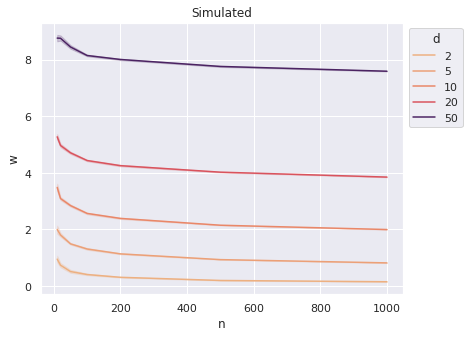

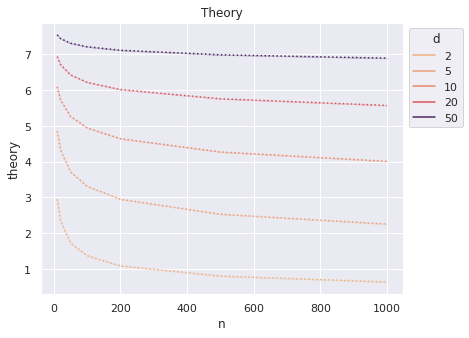

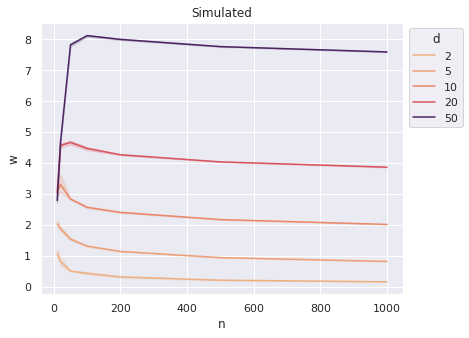

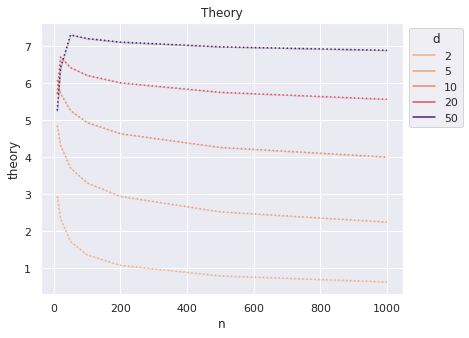

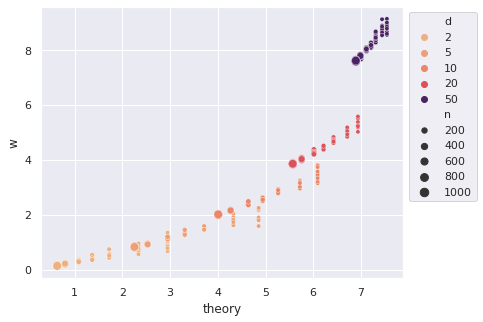

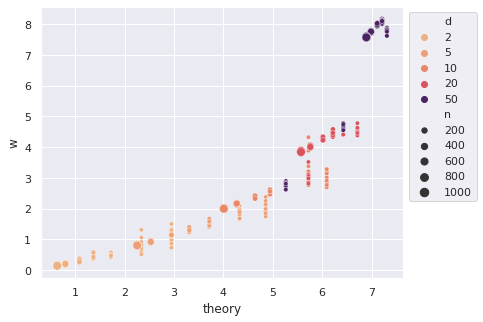

In [142]:
ax = sns.lineplot(data=sim_df, x="n", y="w", hue="d", palette="flare")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Simulated")
plt.show()
ax = sns.lineplot(data=sim_df, x="n", y="theory", hue="d", linestyle="dotted", palette="flare")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Theory")
plt.show()

ax = sns.lineplot(data=double_sim_df, x="n", y="w", hue="d", palette="flare")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Simulated")
plt.show()
ax = sns.lineplot(data=double_sim_df, x="n", y="theory", hue="d", linestyle="dotted", palette="flare")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Theory")
plt.show()

ax = sns.scatterplot(data=sim_df, x="theory", y="w", hue="d", size="n", palette="flare")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

ax = sns.scatterplot(data=double_sim_df, x="theory", y="w", hue="d", size="n", palette="flare")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

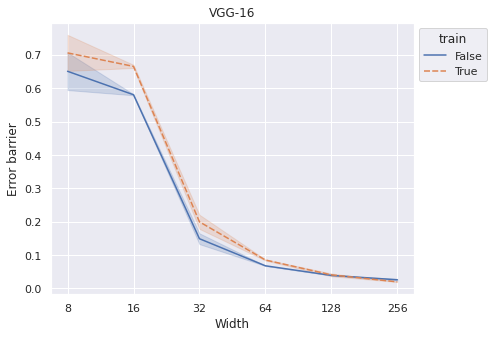

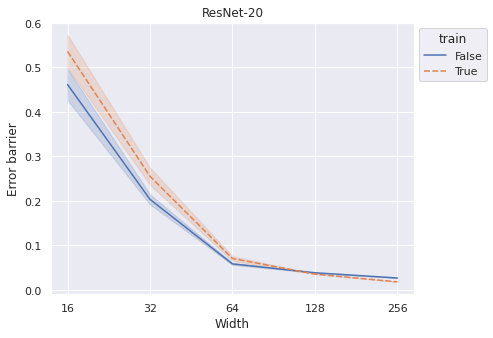

,Unnamed: 0,path,type,interpolation,eval_loss,acc,loss_barrier,acc_barrier,interpolation.idx,eval_loss.idx,acc.idx,loss_barrier.idx,acc_barrier.idx,hash,train,Error barrier,Model,Width
0,0,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-train,25,2.801488,0.1229,2.476766,-0.75975,25,10,12,10,12,688106d9fc0da7db4cebd981434750ee,True,0.75975,VGG-16,8
1,1,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-test,25,2.821677,0.1195,2.295228,-0.70685,25,10,12,10,12,688106d9fc0da7db4cebd981434750ee,False,0.70685,VGG-16,8
2,2,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-train,25,2.121427,0.2370,1.806711,-0.65175,25,12,12,12,12,688106d9fc0da7db4cebd981434750ee,True,0.65175,VGG-16,8
3,3,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-test,25,2.116324,0.2368,1.598660,-0.59435,25,12,12,12,12,688106d9fc0da7db4cebd981434750ee,False,0.59435,VGG-16,8
4,4,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-train,25,1.893064,0.3026,1.809700,-0.66995,25,12,12,12,12,812938fad9d6a452c60de777ad8b9ba2,True,0.66995,VGG-16,16
5,5,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-test,25,1.889911,0.2991,1.450134,-0.58185,25,12,12,12,12,812938fad9d6a452c60de777ad8b9ba2,False,0.58185,VGG-16,16
6,6,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-train,25,2.203060,0.3090,2.117379,-0.66055,25,12,12,12,12,812938fad9d6a452c60de777ad8b9ba2,True,0.66055,VGG-16,16
7,7,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-test,25,2.211052,0.3053,1.780862,-0.57875,25,12,12,12,12,812938fad9d6a452c60de777ad8b9ba2,False,0.57875,VGG-16,16
8,8,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-train,25,0.624504,0.8185,0.614827,-0.17835,25,12,12,12,12,e1ee2ce029f3688fdba8d16bcd72101b,True,0.17835,VGG-16,32
9,9,/home/mila/d/devin.kwok/scratch/2022-nnperm/wi...,level_0-ep160_it0-test,25,0.779906,0.7804,0.337466,-0.13275,25,12,12,12,12,e1ee2ce029f3688fdba8d16bcd72101b,False,0.13275,VGG-16,32


In [145]:
barriers = pd.read_csv("../refactor-outputs/width-stats/barriers.csv")
barriers["hash"] = barriers["path"].apply(lambda x: x.split("lottery_")[1].split("/")[0])
barriers["train"] = barriers["type"].apply(lambda x: "train" in x)
barriers["Error barrier"] = barriers["acc_barrier"].apply(lambda x: -x)
barriers["Model"] = barriers["hash"].apply(lambda x: hash_to_model[x][0])
barriers["Width"] = barriers["hash"].apply(lambda x: hash_to_model[x][1])

for model in ["VGG-16", "ResNet-20"]:
    ax = sns.lineplot(data=barriers[barriers["Model"] == model], x="Width", y="Error barrier", hue="train", style="train")
    ax.set_title(model)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()
barriers

In [52]:
exp_df = []
for file in Path("../refactor-outputs/width-stats/").rglob("stats*.pt"):
    stats = torch.load(file)
    layers = [k for k in stats["layer_weight_all_size"].keys() if not any(x in k for x in ignored_layers)]
    for i, k in enumerate(layers):
        width = stats["layer_weight_all_size"][k]
        weight_sqsum =  stats["layer_weight_ab_sqsum"][k]
        weight_magnitude =  np.mean([stats["layer_weight_a_sqsum"][k], stats["layer_weight_b_sqsum"][k]])
        # activation_sqsum =  stats["layer_activation_ab_sqsum"][k]
        jacobian_sqsum =  stats["layer_jacobian_ab_sqsum"][k]
        jacobian_magnitude =  np.mean([stats["layer_jacobian_a_sqsum"][k], stats["layer_jacobian_b_sqsum"][k]])
        weight_n = stats["layer_weight_ab_n"][k]
        # activation_n = stats["layer_activation_ab_n"][k]
        jacobian_n = stats["layer_jacobian_ab_n"][k]
        hash = str(file).split("lottery_")[1].split("/")[0]
        exp_df.append({
            "path": file,
            "Baseline": "no perm" if "noperm" in str(file) else "permuted",
            "hash": hash,
            "Model": hash_to_model[hash][0],
            "Dataset": hash_to_model[hash][2],
            "Width": int(hash_to_model[hash][1]),
            "Layer type": "norm" if "layernorm" in k else "conv",
            "param": k.split(".")[-1],
            "layer_name": k,
            "Layer": i,
            "Weight squared error": weight_sqsum,
            # "Activation squared error": activation_sqsum,
            "Jacobian squared error": jacobian_sqsum,
            "Weight MSE": weight_sqsum / weight_n,
            # "Activation MSE": activation_sqsum / activation_n,
            "Jacobian MSE": jacobian_sqsum / jacobian_n,
            "Weights": weight_n,
            # "Activations": activation_n,
            "Jacobians": jacobian_n,
            "MSE / weight": weight_sqsum / weight_magnitude,
            "MSE / Jacobian": jacobian_sqsum / jacobian_magnitude,
            "Weight magnitude": weight_magnitude,
            "Jacobian magnitude": jacobian_magnitude,
        })
exp_df = pd.DataFrame(exp_df)

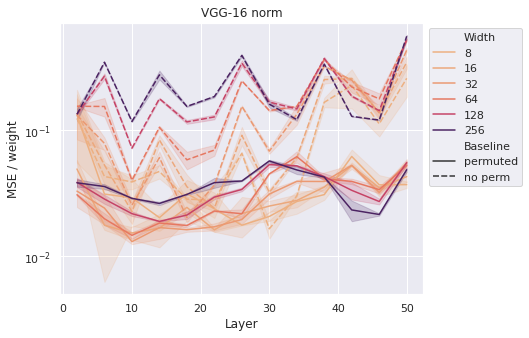

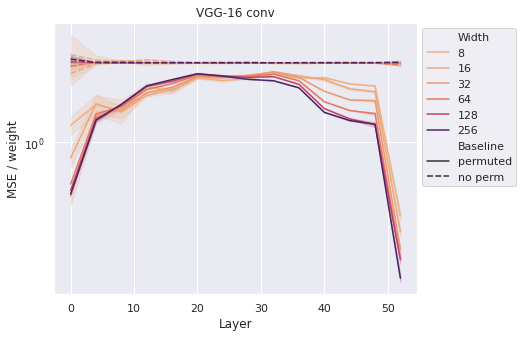

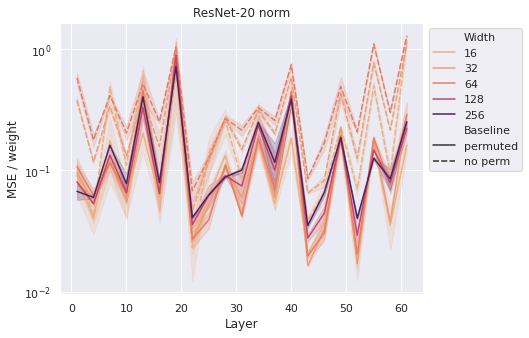

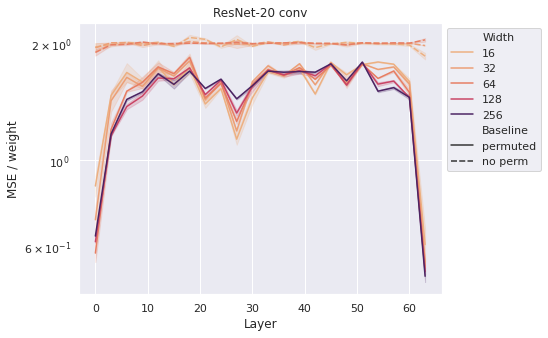

In [138]:
for model in ["VGG-16", "ResNet-20"]:
    for type in ["norm", "conv"]:
        subset = exp_df[(exp_df["Model"] == model) & (exp_df["Layer type"] == type) & (exp_df["param"] == "weight")]
        subset = subset.sort_values("Baseline", ascending=False)
        subset = subset.sort_values("Width")
        ax = sns.lineplot(data=subset, x="Layer", y="MSE / weight", hue="Width", style="Baseline", legend="full", palette="flare")
        ax.set_title(f"{model} {type}")
        ax.set(yscale="log")
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.show()

In [129]:
# IID permutation of trained weights as benchmark
# load checkpoints, combine weights for each layer
# randomly permute, then align each layer
from collections import defaultdict

def permute_and_align(params_a, params_b, by_channel, double_perm):
    if by_channel:
        all_params = np.concatenate([params_a, params_b], axis=0)
    else:
        all_params = np.concatenate([params_a.flatten(), params_b.flatten()])
    all_params = np.random.permutation(all_params)
    rand_a = all_params[len(all_params) // 2:].reshape(params_a.shape)
    rand_b = all_params[:len(all_params) // 2].reshape(params_a.shape)
    rand_a = rand_a.reshape(rand_a.shape[0], -1)
    rand_b = rand_b.reshape(rand_b.shape[0], -1)
    # random draw
    _, cols = linear_sum_assignment(rand_a @ rand_b.T, maximize=True)
    rand_b = rand_b[cols]
    if double_perm:
        _, rows = linear_sum_assignment(rand_a.T @ rand_b, maximize=True)
        rand_b = rand_b[:, rows]
    magnitude = np.mean([np.sum(np.square(rand_a)), np.sum(np.square(rand_b))])
    sqerr = np.sum(np.square(rand_a - rand_b))
    n, d = rand_a.shape
    return n, d, magnitude, sqerr

perm_df = []
for hash, (model, width, dataset) in hash_to_model.items():
    rows = []
    try:
        params_a = torch.load(f"../refactor-outputs/width-ckpts/lottery_{hash}/replicate_1/level_0/main/model_ep160_it0.pth", map_location="cpu")
        params_b = torch.load(f"../refactor-outputs/width-ckpts/lottery_{hash}/replicate_2/level_0/main/model_ep160_it0.pth", map_location="cpu")
    except:
        print(hash, model, width)
        continue
    i = 0
    for k in params_a.keys():
        if "weight" in k and "conv" in k and not "layer.0" in k and not "fc." in k:
            for by_channel in [False, True]:
                for double_perm in [False, True]:
                    n, d, magnitude, sqerr = permute_and_align(params_a[k], params_b[k], by_channel, double_perm)
                    perm_df.append({
                                "Model": model,
                                "Layer": i,
                                "n": n,
                                "d": d,
                                "Theory": min(n ** (d / (d + 1) - 1), d ** (n / (n + 1) - 1)),
                                "MSE / weight": sqerr / magnitude,
                                "by_channel": by_channel,
                                "double_perm": double_perm,
                            })
            i += 1
perm_df = pd.DataFrame(perm_df)

23d95a4841f5114daaeb195dcd3bce62 VGG-16 256
2fec827265eaaaa263b155b4ef1f43a7 ResNet-20 512


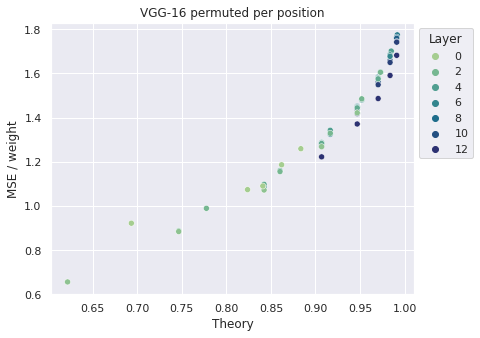

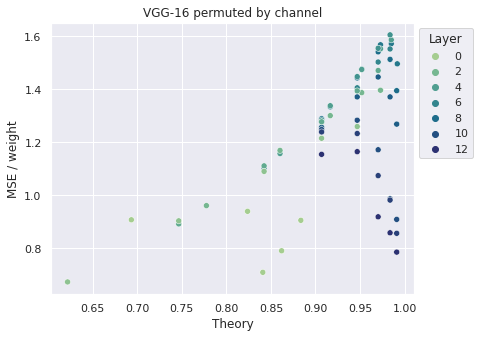

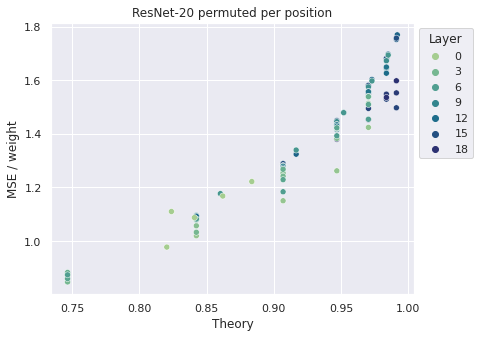

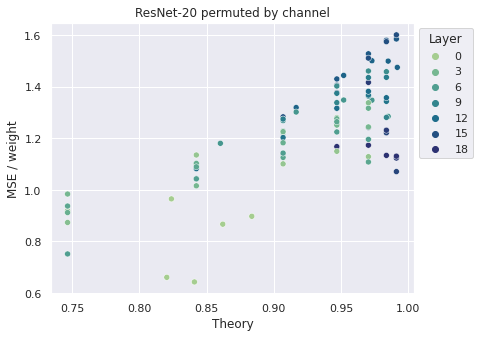

In [139]:
for model in ["VGG-16", "ResNet-20"]:
    for by_channel in [False, True]:
        for double_perm in [True]:
            subset = perm_df[(perm_df["by_channel"] == by_channel) & (perm_df["double_perm"] == double_perm) & (perm_df["Model"] == model)]
            ax = sns.scatterplot(data=subset, x="Theory", y="MSE / weight", hue="Layer", palette="crest")
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
            ax.set_title(model + (" permuted by channel" if by_channel else " permuted per position"))
            plt.show()

In [126]:
# n is number of permuted positions, d is number of non-permuted positions
th_vs_exp_df = []
for name, info in model_info.items():
    for i, (group, axes) in enumerate(info["group_to_axes"].items()):
        n = 0
        d = 0
        weight_sqerr = None
        weight_magnitude = None
        for layer_name, dim, is_input in axes:
            if not is_input:
                shape = info["shape"][layer_name]
                d += np.product(shape) / shape[dim]
                n = shape[dim]

                row = exp_df.loc[(exp_df["Baseline"] == "permuted")  \
                    & (exp_df["Model"] == ("VGG-16" if "vgg" in name else "ResNet-20"))  \
                    & (exp_df["Dataset"] == "cifar10")  \
                    & (exp_df["Width"] == int(name.split("_")[-1]))  \
                    & (exp_df["layer_name"] == layer_name)]
                if weight_sqerr is None:
                    weight_sqerr = row["Weight squared error"].to_numpy()
                else:
                    weight_sqerr += row["Weight squared error"].to_numpy()
                if weight_magnitude is None:
                    weight_magnitude = row["Weight magnitude"].to_numpy()
                else:
                    weight_magnitude += row["Weight magnitude"].to_numpy()
        if weight_sqerr is not None:
            for sqerr, magnitude in zip(weight_sqerr, weight_magnitude):
                th_vs_exp_df.append({
                    "Model": name,
                    "Layer": i,
                    "n": n,
                    "d": d,
                    "Theory": min(n ** (d / (d + 1) - 1), d ** (n / (n + 1) - 1)),
                    "MSE / weight": sqerr / magnitude,
                })

th_vs_exp_df = pd.DataFrame(th_vs_exp_df)
th_vs_exp_df

,Model,Layer,n,d,Theory,MSE / weight
0,cifar_vgg_16_8,0,8,30.0,0.685292,0.952661
1,cifar_vgg_16_8,0,8,30.0,0.685292,0.876674
2,cifar_vgg_16_8,1,8,75.0,0.618956,1.234798
3,cifar_vgg_16_8,1,8,75.0,0.618956,1.035208
4,cifar_vgg_16_8,2,16,75.0,0.775715,1.180952
...,...,...,...,...,...,...
261,cifar_resnet_20_256,9,1024,9218.0,0.991133,1.616453
262,cifar_resnet_20_256,10,1024,9218.0,0.991133,1.649670
263,cifar_resnet_20_256,10,1024,9218.0,0.991133,1.632468
264,cifar_resnet_20_256,11,1024,9218.0,0.991133,1.316907


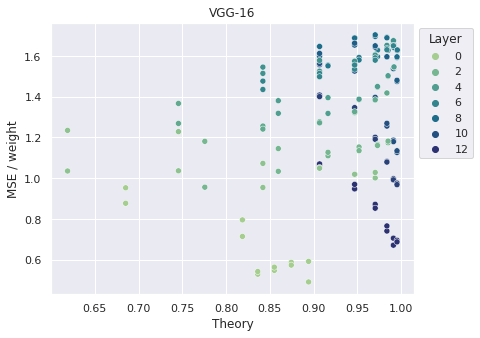

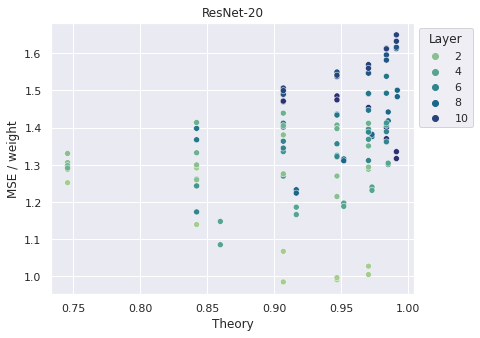

In [141]:
# # plot theoretical value versus experimental MSE / magnitude
ax = sns.scatterplot(data=th_vs_exp_df[th_vs_exp_df["Model"].apply(lambda x: "vgg" in x)], x="Theory", y="MSE / weight", hue="Layer", palette="crest")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("VGG-16")
plt.show()
ax = sns.scatterplot(data=th_vs_exp_df[th_vs_exp_df["Model"].apply(lambda x: "resnet" in x)], x="Theory", y="MSE / weight", hue="Layer", palette="crest")
ax.set_title("ResNet-20")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()